In [ ]:
#If dependencies are missing, uncomment and run the following line:
#!pip install -r requirements.txt

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import autokeras as ak
from matplotlib import pyplot as plt
import numpy as np
from utils import *
from neural_net import NN
from torch import nn
from sklearn.linear_model import LinearRegression
import torch, torchvision




In [2]:

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_path = "orders_autumn_2020.csv"
data = pd.read_csv(dataset_path).dropna()

add_hours_mins_cols(data)
add_distance_col(data)

X_columns = ["ITEM_COUNT",
        "DISTANCES_KM",
        "ESTIMATED_DELIVERY_MINUTES",
        "WIND_SPEED", "TEMPERATURE"]

Y_columns = ["ACTUAL_DELIVERY_MINUTES"]


X = data[X_columns]
Y = data[Y_columns]

(18429, 4)
[0.59968782 1.17992593 1.39110364 0.55631779 3.30509173]


In [4]:
x_train, x_test = split_data(X.values, 0.7)
y_train, y_test = split_data(Y.values, 0.7)


y_test, y_val = split_data(y_test, 0.7)
x_test, x_val = split_data(x_test, 0.7)

#we need to know at which indices does the test split start and end, in order to make correct splits when testing
def get_test_y_start_end(data_len, split_ratio=0.7):

    start = int(data_len * split_ratio)
    end = int(start + (data_len - start) * split_ratio)

    return start, end

y_estimate_start, y_estimate_end = get_test_y_start_end(len(Y.values), 0.7)


In [5]:
# Training linear regression model

regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

Linear regression MSE:
76.78814026212972
Linear regression MAE:
7.134414599905561


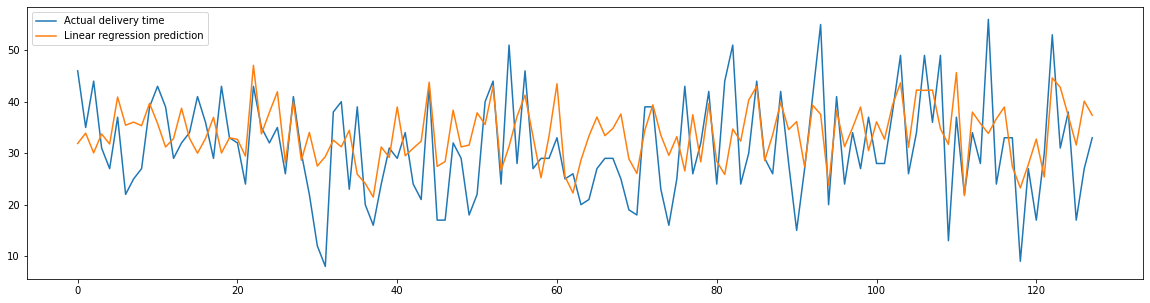

In [6]:
# Testing linear regression model

regressor_pred = regressor.predict(x_test)

regressor_mse = mean_squared_error(y_test, regressor_pred)
print("Linear regression MSE:")
print(regressor_mse)

regressor_mae = mean_absolute_error(y_test, regressor_pred)
print("Linear regression MAE:")
print(regressor_mae)

plot_indices = np.random.choice(len(regressor_pred), 128)
plt.figure(figsize=(20,5))
plt.plot(y_test[plot_indices], label="Actual delivery time")
plt.plot(regressor_pred[plot_indices], label="Linear regression prediction")
#Uncomment the next line if you want to plot the estimated values from the dataset as well
#plt.plot(data["ESTIMATED_DELIVERY_MINUTES"].values[plot_indices], label="Provided estimates")

plt.legend()
plt.show()

In [7]:
# Training a neural network model

nn_model = NN(5).to(device)

In [8]:
nn_model.train()
nn_model.train_model(
    torch_np(x_train).to(device), 
    torch_np(y_train).to(device), 
    torch_np(x_val).to(device), 
    torch_np(y_val).to(device), 
    epochs=150, batch_size=128, validation_step=10)

tensor(33.0263, grad_fn=<DivBackward0>)
 
 Validation loss:
tensor(29.1623, grad_fn=<SmoothL1LossBackward>) 

tensor(32.6445, grad_fn=<DivBackward0>)
tensor(32.0701, grad_fn=<DivBackward0>)
tensor(31.0656, grad_fn=<DivBackward0>)
tensor(29.3007, grad_fn=<DivBackward0>)
tensor(27.3974, grad_fn=<DivBackward0>)
tensor(24.5387, grad_fn=<DivBackward0>)
tensor(21.6372, grad_fn=<DivBackward0>)
tensor(18.7491, grad_fn=<DivBackward0>)
tensor(16.6339, grad_fn=<DivBackward0>)
tensor(15.2070, grad_fn=<DivBackward0>)
 
 Validation loss:
tensor(11.3460, grad_fn=<SmoothL1LossBackward>) 

tensor(14.3658, grad_fn=<DivBackward0>)
tensor(13.9015, grad_fn=<DivBackward0>)
tensor(13.7012, grad_fn=<DivBackward0>)
tensor(13.3398, grad_fn=<DivBackward0>)
tensor(13.4878, grad_fn=<DivBackward0>)
tensor(12.9864, grad_fn=<DivBackward0>)
tensor(13.1206, grad_fn=<DivBackward0>)
tensor(12.8214, grad_fn=<DivBackward0>)
tensor(13.1258, grad_fn=<DivBackward0>)
tensor(12.8663, grad_fn=<DivBackward0>)
 
 Validation loss:


In [9]:
# Testing the neural network

#Uncomment the next line if you want to test with the saved best performing model (saved pickle):
#nn_model = torch.load("best_model")

loss, pred = nn_model.test(torch.from_numpy(x_test.astype(np.float32)).to(device), torch.from_numpy(y_test.astype(np.float32)).to(device))

print("Huber Loss on test data: ", loss)

Huber Loss on test data:  tensor(6.3385, grad_fn=<SmoothL1LossBackward>)


In [10]:
estimated_time = data["ESTIMATED_DELIVERY_MINUTES"].values

nn_model_mse = mean_squared_error(y_test, pred.detach())


nn_model_mae = mean_absolute_error(y_test, pred.detach())

print("Neural Network MSE", nn_model_mse)

print("Neural network MAE ", nn_model_mae)

Neural Network MSE 72.73498437841329
Neural network MAE  6.823317536642385


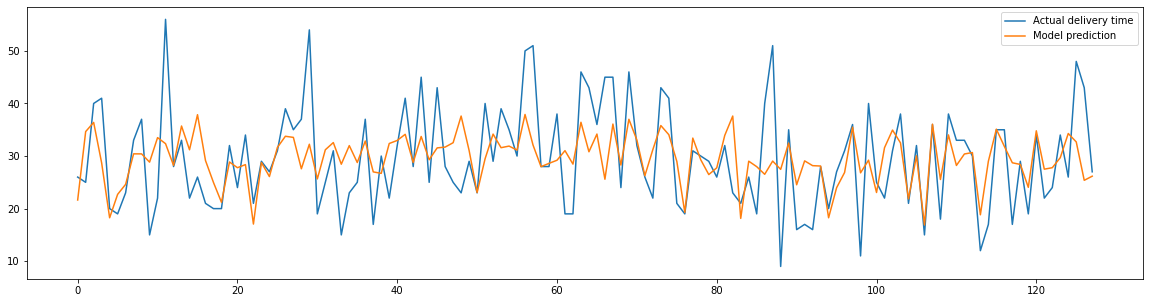

In [11]:

plot_indices = np.random.choice(len(pred), 128)

plt.figure(figsize=(20,5))
plt.plot(y_test[plot_indices], label="Actual delivery time")
plt.plot(pred[plot_indices], label="Model prediction")
#Uncomment the next line if you want to plot the estimated values from the dataset as well
#plt.plot(data["ESTIMATED_DELIVERY_MINUTES"].values[plot_indices], label="Provided estimates")

plt.legend()
plt.show()



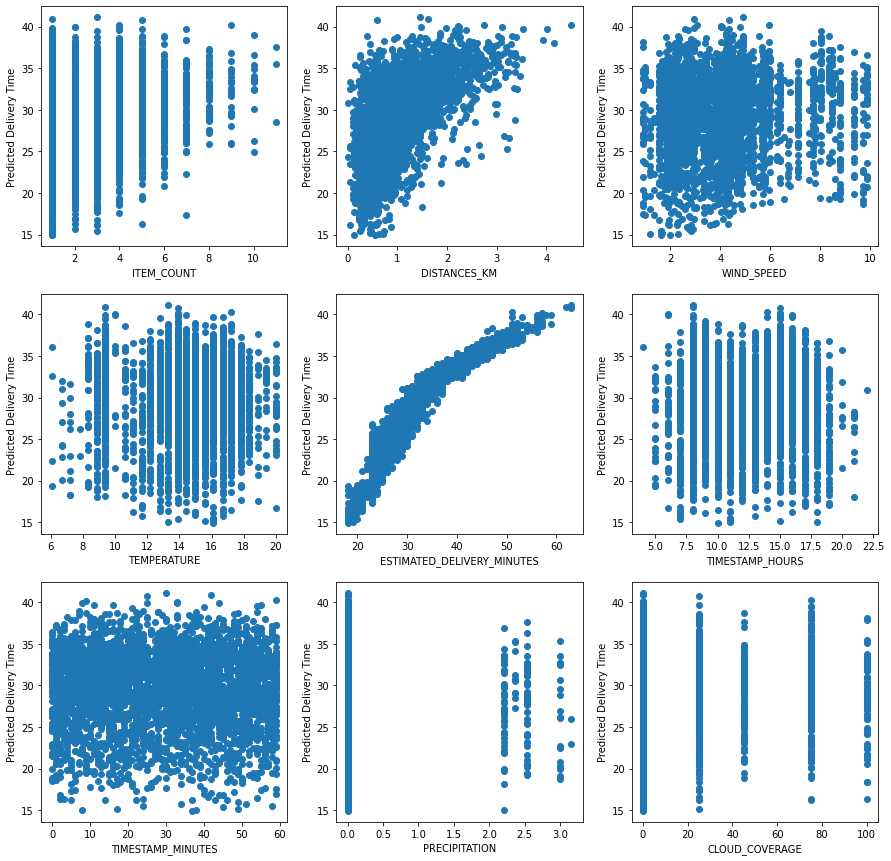

In [12]:
scatter_all_parameters(pred, data[y_estimate_start:y_estimate_end])

In [13]:
provided_mae = mean_absolute_error(Y.values, estimated_time)
provided_mse = mean_squared_error(Y.values, estimated_time)

print("Provided delivery time estimate MAE ", provided_mae, '\n')
print("Provided delivery time estimate MSE", provided_mse, '\n')
print("Linear regression estimate MAE", regressor_mae, '\n')
print("Linear regression estimate MSE", regressor_mse, '\n')
print("Neural network estimate MAE", nn_model_mae, '\n')
print("Neural network estimate MSE", nn_model_mse)

Provided delivery time estimate MAE  7.253730533398448 

Provided delivery time estimate MSE 82.10033100005427 

Linear regression estimate MAE 7.134414599905561 

Linear regression estimate MSE 76.78814026212972 

Neural network estimate MAE 6.823317536642385 

Neural network estimate MSE 72.73498437841329


In [ ]:
# Attempt to make Autokeras do all the work
#Feel free not to run this one
reg = ak.StructuredDataRegressor(overwrite=True, max_trials=300)
reg.fit(x_train, y_train, epochs=100)
ak_pred = reg.predict(x_test)

ak_mse = mean_squared_error(ak_pred, y_test)
ak_mae = mean_absolute_error(ak_pred, y_test)
print("Autokeras MSE:", ak_mse)
print("Autokeras MAE:", ak_mae)